In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt

#from torch import nn
from pathlib import Path
from typing import Union

sys.path.append(os.path.expanduser('~/Documents/Medley'))


In [2]:
pspath = Path('/scistor/ivm/jsn295/Medi/predselec/')

In [3]:
expids = [ p.name.split('_')[0] for p in pspath.glob('*.json')]

In [4]:
def extract_properties(expid : str) -> pd.DataFrame:
    with open(pspath / f'{expid}_experiment.json',mode = 'rt') as f:
        dc = json.load(f)
    return dc

def _finditem(obj, key): 
    """https://stackoverflow.com/questions/14962485/finding-a-key-recursively-in-a-dictionary"""
    if key in obj: 
        return obj[key]
    for k, v in obj.items():
        if isinstance(v,dict):
            item = _finditem(v, key)
            if item is not None:
                return item

def return_experiments_with(key: str, value: Union[str, int]) -> dict:
    """
    Loops through experiments and returns those dicts
    for which a value under the key equals value (optional)
    at any level in the potentially nested hierarchy
    """
    dicts = {expid: extract_properties(expid) for expid in expids}
    returndicts = {}
    for expid, dc in dicts.items():
        item = _finditem(dc, key)
        if item == value:
            returndicts.update({expid:dc})
    return returndicts

def return_unique_values(key: str) -> list:
    """
    Returns the unique values for a key, plus a list of
    experiment ids containing that value
    """
    dicts = {expid: extract_properties(expid) for expid in expids}
    returndict = {}
    for expid, dc in dicts.items():
        item = _finditem(dc, key)
        if item is not None:
            try:
                expidlist = returndict[item]
                expidlist.append(expid)
            except KeyError: # If it is not yet present
                expidlist = [expid]
            returndict.update({item:expidlist})
    return returndict

def load_results(expid: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    predictor selection results as saved
    """
    resultspath = pspath / f'{expid}_results.csv'
    df = pd.read_csv(resultspath, sep = ';', index_col = 0)
    df.index.name = 'npredictors'
    objecttypes = df.dtypes.loc[(df.dtypes == object).values]
    for col in objecttypes.index:
        if not col == 'cv_scores':
            f = lambda s: eval(s)
        else:
            f = lambda s: [float(f) for f in s[1:-1].split(' ') if f]
            #f = lambda s: s[2:-2].split(' ')
        df.loc[:,col] = df.loc[:,col].apply(f)
    cv_scores = pd.DataFrame(list(df['cv_scores'].values), index = df.index)
    cv_scores.columns.name = 'fold'
    return df.drop('cv_scores', axis = 1), cv_scores

def compare_scores(expids : list, cv = True) -> pd.DataFrame:
    scoredfs = {}
    for expid in expids:
        df, cv_scores = load_results(expid)
        if cv:
            scoredfs.update({expid:cv_scores})
        else:
            scoredfs.update({expid:df[['avg_score']]})
    scoredf = pd.concat(scoredfs, axis = 0)
    return scoredf

In [5]:
return_experiments_with('target_var','SPI3')

{'9809047ebb': {'prep_kwargs': {'target_region': {'include': {'iberia': [-9.8,
      35.98,
      8,
      44.6],
     'italy': [8, 35, 18, 45.63]},
    'exclude': {'north_africa': [-1.45, 34.457, 11.217, 36.972],
     'eastadriatic': [15, 43, 20, 48],
     'tunesia': [5, 30, 12, 38],
     'pyrenees': [-2, 41.8, 3.7, 45.63]}},
   'target_var': 'SPI3',
   'minsamples': 10,
   'resampling': 'multi',
   'resampling_kwargs': {'precursor_agg': 1,
    'n': 3,
    'separation': 0,
    'target_agg': 1,
    'firstmonth': 12,
    'lastmonth': 3}},
  'startyear': 1950,
  'endyear': 2023,
  'fraction_valid': 0.8,
  'cv_kwargs': {'n_temporal': 5},
  'estimator_kwargs': {'n_estimators': 500,
   'max_depth': 10,
   'min_samples_split': 0.01},
  'sequential_kwargs': {'k_features': 20,
   'forward': True,
   'scoring': 'r2',
   'n_jobs': 10}},
 'deb4021d58': {'prep_kwargs': {'target_region': {'include': {'iberia': [-9.8,
      35.98,
      8,
      44.6],
     'italy': [8, 35, 18, 45.63]},
    'exclude

In [6]:
ids = list(return_experiments_with('scoring','r2').keys())

In [7]:
test = compare_scores(ids, cv = False)

<Axes: xlabel='npredictors'>

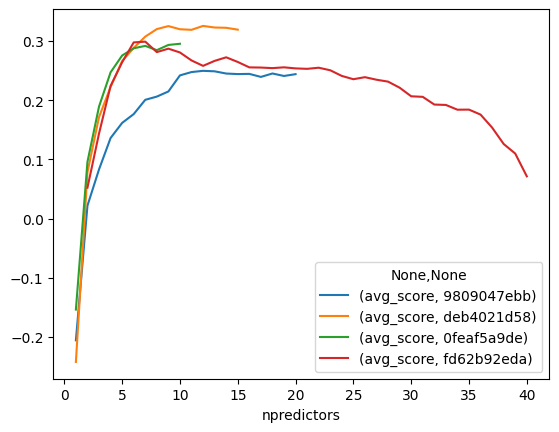

In [8]:
test.unstack(0).plot()

In [191]:
return_unique_values('firstmonth') # Reason for the worse score is including december

{12: ['9809047ebb'],
 1: ['deb4021d58', '6034f0405d', '0feaf5a9de', 'fd62b92eda']}

In [195]:
return_unique_values('lastmonth')

{3: ['9809047ebb', 'deb4021d58', '6034f0405d', '0feaf5a9de', 'fd62b92eda']}

In [219]:
return_unique_values('n') # as both the best and the worst have n = 3

{3: ['9809047ebb', 'deb4021d58'],
 1: ['6034f0405d', '0feaf5a9de', 'fd62b92eda']}

In [192]:
return_unique_values('max_depth') # Reason strong decline after 7 predictors seems to be deepest trees.

{10: ['9809047ebb', 'deb4021d58', '0feaf5a9de'],
 5: ['6034f0405d'],
 15: ['fd62b92eda']}

In [196]:
return_unique_values('min_samples_split')

{0.01: ['9809047ebb', '6034f0405d', 'fd62b92eda'], 0.001: ['deb4021d58']}

In [202]:
df_forward, sc = load_results('deb4021d58')

<Axes: xlabel='npredictors'>

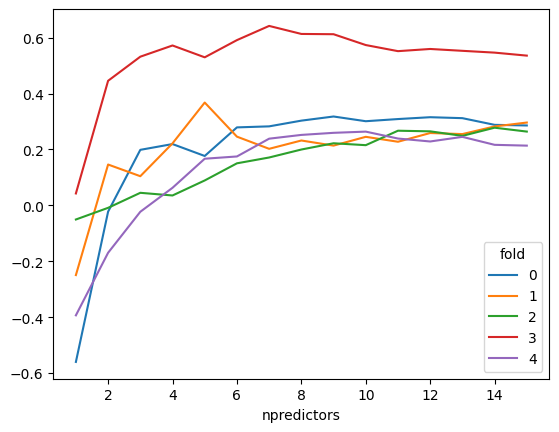

In [203]:
sc.plot()

In [220]:
df_forward.loc[10,'feature_names']

((('enso', 34, 'ersstv5'), -1),
 (('nao', 0, 'ncep'), -2),
 (('nao', 0, 'station'), -1),
 (('snao', 0, 'ncep'), -1),
 (('ao', 0, 'ncep'), -1),
 (('med_u250_latmax', 0, 'era5'), -1),
 (('med_u250', 20, 'era5'), -1),
 (('med_u250', 40, 'era5'), -3),
 (('med_u500', 50, 'era5'), -1),
 (('med_u500', 60, 'era5'), -1))

In [213]:
df_forward.loc[4,'feature_names']

((('enso', 34, 'ersstv5'), -1),
 (('nao', 0, 'station'), -1),
 (('ao', 0, 'ncep'), -1),
 (('med_u250', 20, 'era5'), -1))

In [214]:
df_backward, sc_backward = load_results('fd62b92eda')

In [218]:
df_backward.loc[5,'feature_names']

((('enso', 34, 'ersstv5'), -1),
 (('med_u250_latmax', 0, 'era5'), -1),
 (('atl_u250', 30, 'era5'), -1),
 (('med_u500', 20, 'era5'), -1),
 (('med_u500', 60, 'era5'), -1))

In [145]:
preds = pd.read_parquet('/scistor/ivm/jsn295/Medi/monthly/complete.parquet')

In [153]:
preds.loc[:,[a[0] for a in df.loc[10,'feature_names']]]

name          enso     nao   ao  qbo med_u250_latmax med_u250 med_u500_latmax  \
subindex        34      0    0    0               0        60              0    
product    ersstv5 station ncep ncep            era5     era5            era5   
1821-01-01     NaN     NaN  NaN  NaN             NaN      NaN             NaN   
1821-02-01     NaN     NaN  NaN  NaN             NaN      NaN             NaN   
1821-03-01     NaN     NaN  NaN  NaN             NaN      NaN             NaN   
1821-04-01     NaN     NaN  NaN  NaN             NaN      NaN             NaN   
1821-05-01     NaN     NaN  NaN  NaN             NaN      NaN             NaN   
...            ...     ...  ...  ...             ...      ...             ...   
2023-08-01     NaN     NaN  NaN  NaN             NaN      NaN             NaN   
2023-09-01     NaN     NaN  NaN  NaN             NaN      NaN             NaN   
2023-10-01     NaN     NaN  NaN  NaN             NaN      NaN             NaN   
2023-11-01     NaN     NaN  NaN  NaN             NaN      NaN             NaN   
2023-12-01     NaN     NaN  NaN  NaN             NaN      NaN             NaN   

name       med_u500      atl_u500  
subindex         20   60       40  
product        era5 era5     era5  
1821-01-01      NaN  NaN      NaN  
1821-02-01      NaN  NaN      NaN  
1821-03-01      NaN  NaN      NaN  
1821-04-01      NaN  NaN      NaN  
1821-05-01      NaN  NaN      NaN  
...             ...  ...      ...  
2023-08-01      NaN  NaN      NaN  
2023-09-01      NaN  NaN      NaN  
2023-10-01      NaN  NaN      NaN  
2023-11-01      NaN  NaN      NaN  
2023-12-01      NaN  NaN      NaN  

[2436 rows x 10 columns]

In [149]:
preds

name          enso                             amo          amoc  nao          \
subindex      12      3       34      4       0             0    0              
product    ersstv5 ersstv5 ersstv5 ersstv5 ersstv5 hadsst4 rapid ncep station   
1821-01-01     NaN     NaN     NaN     NaN     NaN     NaN   NaN  NaN     NaN   
1821-02-01     NaN     NaN     NaN     NaN     NaN     NaN   NaN  NaN     NaN   
1821-03-01     NaN     NaN     NaN     NaN     NaN     NaN   NaN  NaN     NaN   
1821-04-01     NaN     NaN     NaN     NaN     NaN     NaN   NaN  NaN     NaN   
1821-05-01     NaN     NaN     NaN     NaN     NaN     NaN   NaN  NaN     NaN   
...            ...     ...     ...     ...     ...     ...   ...  ...     ...   
2023-08-01     NaN     NaN     NaN     NaN     NaN     NaN   NaN  NaN     NaN   
2023-09-01     NaN     NaN     NaN     NaN     NaN     NaN   NaN  NaN     NaN   
2023-10-01     NaN     NaN     NaN     NaN     NaN     NaN   NaN  NaN     NaN   
2023-11-01     NaN     NaN     NaN     NaN     NaN     NaN   NaN  NaN     NaN   
2023-12-01     NaN     NaN     NaN     NaN     NaN     NaN   NaN  NaN     NaN   

name       snao  ... atl_u500           vortex_u20 atl_eke_latmax atl_eke  \
subindex   0     ...     40   50   60         7080           0       20     
product    ncep  ...     era5 era5 era5       era5           ERA5    ERA5   
1821-01-01  NaN  ...      NaN  NaN  NaN        NaN            NaN     NaN   
1821-02-01  NaN  ...      NaN  NaN  NaN        NaN            NaN     NaN   
1821-03-01  NaN  ...      NaN  NaN  NaN        NaN            NaN     NaN   
1821-04-01  NaN  ...      NaN  NaN  NaN        NaN            NaN     NaN   
1821-05-01  NaN  ...      NaN  NaN  NaN        NaN            NaN     NaN   
...         ...  ...      ...  ...  ...        ...            ...     ...   
2023-08-01  NaN  ...      NaN  NaN  NaN        NaN            NaN     NaN   
2023-09-01  NaN  ...      NaN  NaN  NaN        NaN            NaN     NaN   
2023-10-01  NaN  ...      NaN  NaN  NaN        NaN            NaN     NaN   
2023-11-01  NaN  ...      NaN  NaN  NaN        NaN            NaN     NaN   
2023-12-01  NaN  ...      NaN  NaN  NaN        NaN            NaN     NaN   

name                            
subindex   30   40   50   60    
product    ERA5 ERA5 ERA5 ERA5  
1821-01-01  NaN  NaN  NaN  NaN  
1821-02-01  NaN  NaN  NaN  NaN  
1821-03-01  NaN  NaN  NaN  NaN  
1821-04-01  NaN  NaN  NaN  NaN  
1821-05-01  NaN  NaN  NaN  NaN  
...         ...  ...  ...  ...  
2023-08-01  NaN  NaN  NaN  NaN  
2023-09-01  NaN  NaN  NaN  NaN  
2023-10-01  NaN  NaN  NaN  NaN  
2023-11-01  NaN  NaN  NaN  NaN  
2023-12-01  NaN  NaN  NaN  NaN  

[2436 rows x 49 columns]

In [137]:
df.drop('cv_scores', axis = 1)

,feature_idx,avg_score,feature_names,ci_bound,std_dev,std_err
npredictors,,,,,,
1,"(29,)",-0.205735,"(((ao, 0, ncep), -1),)",0.250332,0.194767,0.097383
2,"(29, 43)",0.021869,"(((ao, 0, ncep), -1), ((qbo, 0, ncep), -2))",0.186622,0.145198,0.072599
3,"(29, 43, 47)",0.082973,"(((ao, 0, ncep), -1), ((qbo, 0, ncep), -2), ((...",0.170954,0.133008,0.066504
4,"(22, 29, 43, 47)",0.136033,"(((nao, 0, station), -2), ((ao, 0, ncep), -1),...",0.172547,0.134248,0.067124
5,"(22, 29, 43, 47, 60)",0.161591,"(((nao, 0, station), -2), ((ao, 0, ncep), -1),...",0.164638,0.128094,0.064047
6,"(22, 29, 43, 47, 60, 83)",0.176457,"(((nao, 0, station), -2), ((ao, 0, ncep), -1),...",0.151084,0.117549,0.058774
7,"(8, 22, 29, 43, 47, 60, 83)",0.200572,"(((enso, 34, ersstv5), -1), ((nao, 0, station)...",0.148816,0.115784,0.057892
8,"(8, 22, 29, 43, 47, 60, 83, 108)",0.206025,"(((enso, 34, ersstv5), -1), ((nao, 0, station)...",0.119937,0.093315,0.046658
9,"(8, 22, 29, 43, 47, 60, 83, 98, 108)",0.214656,"(((enso, 34, ersstv5), -1), ((nao, 0, station)...",0.104594,0.081378,0.040689
